In [160]:
import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

In [161]:
### Assignment Owner: Tian Wang

#######################################
####Q2.1: Normalization


def feature_normalization(train, test):
    """Rescale the data so that each feature in the training set is in
    the interval [0,1], and apply the same transformations to the test
    set, using the statistics computed on the training set.

    Args:
        train - training set, a 2D numpy array of size (num_instances, num_features)
        test  - test set, a 2D numpy array of size (num_instances, num_features)
    Returns:
        train_normalized - training set after normalization
        test_normalized  - test set after normalization

    """
    ### Note- to rescale a feature so it is in the interval [0,1], we use
    ### x' = 1/(x_max + x_min) * x - x_min/(x_max + x_min).
        
    slopes = 1.0/(np.amax(train, axis=0) - np.amin(train, axis=0))
    intercepts = -np.amin(train, axis=0)/(np.amax(train, axis=0) - np.amin(train, axis=0))
    train_normalized = train*slopes + intercepts
    test_normalized = test*slopes + intercepts
    
    return train_normalized, test_normalized

In [162]:
###Load, split, and scale data
def load_split_proc_data():
    #Loading the dataset
    print('loading the dataset')
    
    df = pd.read_csv('hw1-data.csv', delimiter=',')
    X = df.values[:,:-1]
    y = df.values[:,-1]

    print('Split into Train and Test')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =100, random_state=10)

    print("Scaling all to [0, 1]")
    X_train, X_test = feature_normalization(X_train, X_test)
    X_train = np.hstack((X_train, np.ones((X_train.shape[0], 1))))  # Add bias term
    X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1)))) # Add bias term

    return {'X_train': X_train,'X_test':  X_test, 'y_train':  y_train, 'y_test': y_test}

In [163]:
########################################
####Q2.2.5: The square loss function

def compute_square_loss(X, y, theta, lambda_reg=0):
    """
    Given a set of X, y, theta, compute the square loss for predicting y with X*theta
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D array of size (num_features)
    
    Returns:
        loss - the square loss, scalar
    """
    return 1.0/(2.0 * X.shape[0]) * (np.dot(np.dot(X,theta) - y, np.dot(X,theta) - y))

In [164]:
X_1 = np.array([[0,1],[2,3]])
y_1 = np.array([2,4])
theta_1 = np.array([0,2])
theta_2 = np.array([0,1.5])

compute_square_loss(X_1, y_1, theta_1)

1.0

In [165]:
compute_square_loss(X_1, y_1, theta_2)

0.125

In [166]:
########################################
###Q2.2.7: compute the gradient of square loss function
def compute_square_loss_gradient(X, y, theta, lambda_reg=0):
    """
    Compute gradient of the square loss (as defined in compute_square_loss), at the point theta.
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
    
    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    return 1.0/X.shape[0] * np.dot((np.dot(X,theta) - y), X)

In [167]:
compute_square_loss_gradient(X_1, y_1, theta_1)

array([ 2.,  3.])

In [168]:
###########################################
###Q2.3.1: Gradient Checker
#Getting the gradient calculation correct is often the trickiest part
#of any gradient-based optimization algorithm.  Fortunately, it's very
#easy to check that the gradient calculation is correct using the
#definition of gradient.
#See http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization
def grad_checker(X, y, theta, epsilon=0.01, tolerance=1e-4): 
    """Implement Gradient Checker
    Check that the function compute_square_loss_gradient returns the
    correct gradient for the given X, y, and theta.

    Let d be the number of features. Here we numerically estimate the
    gradient by approximating the directional derivative in each of
    the d coordinate directions: 
    (e_1 = (1,0,0,...,0), e_2 = (0,1,0,...,0), ..., e_d = (0,...,0,1) 

    The approximation for the directional derivative of J at the point
    theta in the direction e_i is given by: 
    ( J(theta + epsilon * e_i) - J(theta - epsilon * e_i) ) / (2*epsilon).

    We then look at the Euclidean distance between the gradient
    computed using this approximation and the gradient computed by
    compute_square_loss_gradient(X, y, theta).  If the Euclidean
    distance exceeds tolerance, we say the gradient is incorrect.

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        epsilon - the epsilon used in approximation
        tolerance - the tolerance error
    
    Return:
        A boolean value indicate whether the gradient is correct or not

    """
    true_gradient = compute_square_loss_gradient(X, y, theta) #the true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    
    for i in np.arange(num_features):
        e_i = np.zeros(num_features)
        e_i[i] += 1.0
        approx_grad[i] += (compute_square_loss(X, y, theta + epsilon*e_i) - \
                           compute_square_loss(X, y, theta - epsilon*e_i)) / (2*epsilon)
    
    if np.dot(true_gradient - approx_grad, true_gradient - approx_grad) ** 0.5 > tolerance:
        return False
    
    else:
        return True

In [169]:
#################################################
###Q2.3.2: Generic Gradient Checker
def generic_gradient_checker(X, y, theta, objective_func, gradient_func, lambda_reg=0, epsilon=0.01, tolerance=1e-4):
    """
    The functions takes objective_func and gradient_func as parameters. And check whether
    gradient_func(X, y, theta) returned
    the true gradient for objective_func(X, y, theta).
    Eg: In LSR, the objective_func = compute_square_loss, and gradient_func = compute_square_loss_gradient
    """
    true_gradient = gradient_func(X, y, theta, lambda_reg) #the true gradient
    num_features = theta.shape[0]
    approx_grad = np.zeros(num_features) #Initialize the gradient we approximate
    
    for i in np.arange(num_features):
        e_i = np.zeros(num_features)
        e_i[i] += 1.0
        approx_grad[i] += (objective_func(X, y, theta + epsilon*e_i, lambda_reg) - \
                           objective_func(X, y, theta - epsilon*e_i, lambda_reg)) / (2*epsilon)

        
    if np.dot(true_gradient - approx_grad, true_gradient - approx_grad) ** 0.5 > tolerance:
        print true_gradient
        print approx_grad
        return False
    
    else:
        return True

In [170]:
####################################
####Q2.4.1: Batch Gradient Descent
def batch_grad_descent(X, y, alpha=0.1, num_iter=1000, check_gradient=False):
    """
    In this question you will implement batch gradient descent to
    minimize the square loss objective
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        num_iter - number of iterations to run 
        check_gradient - a boolean value indicating whether checking the gradient when updating
        
    Returns:
        theta_hist - store the the history of parameter vector in iteration, 2D numpy array of size
                    (num_iter+1, num_features)  for instance, theta in iteration 0 should be theta_hist[0],
                    theta in ieration (num_iter) is theta_hist[-1]
        loss_hist - the history of objective function vector, 1D numpy array of size (num_iter+1) 
    """
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #initialize loss_hist
    theta = np.ones(num_features) #initialize theta
    
    ##Update loss_hist and theta_hist with iteration 0 values:
    
    theta_hist[0,] = theta
    loss_hist[0] = compute_square_loss(X, y, theta)
    
    ##List of divergent alpha's
    alpha_too_large = set()
    
    if check_gradient:
        for i in range(num_iter):
            if grad_checker(X, y, theta):
                grad = compute_square_loss_gradient(X, y, theta)
                norm_grad = grad / (np.dot(grad, grad)**0.5)
                theta = theta - alpha * norm_grad
                theta_hist[i+1,] = theta
                loss_hist[i+1] = compute_square_loss(X, y, theta)
            else:
                alpha_too_large.add(alpha)
                
    else:
        for i in range(num_iter):
            theta = theta - alpha * compute_square_loss_gradient(X, y, theta)
            theta_hist[i+1,] = theta
            loss_hist[i+1] = compute_square_loss(X, y, theta)
    
    if len(alpha_too_large) > 0:
        print 'Note: gradient descent failed for step size {}'.format(", ".join([str(i) for i in alpha_too_large]))
    return theta_hist, loss_hist

loading the dataset
Split into Train and Test
Scaling all to [0, 1]


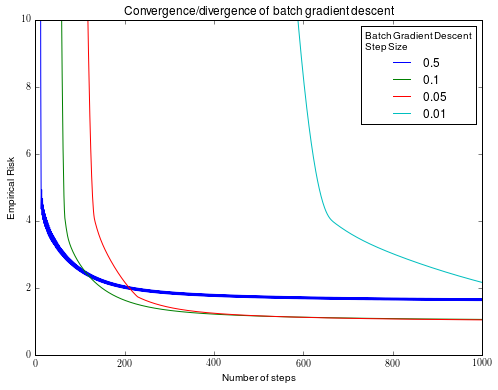

In [171]:
####################################
###Q2.4.2: Experiment with step size.
%matplotlib inline

data = load_split_proc_data()
X = data['X_train']
y = data['y_train']
step_sizes = [0.5,0.1,0.05,0.01]
plt.figure(figsize=(8,6))
plt.ylim((0,10))
for alpha in step_sizes:
    plt.plot(np.arange(1001.0), batch_grad_descent(X, y, alpha, check_gradient=True)[1], label=str(alpha))
    plt.legend(title='Batch Gradient Descent\nStep Size')
    plt.xlabel('Number of steps')
    plt.ylabel('Empirical Risk')
    plt.title('Convergence/divergence of batch gradient descent')
plt.savefig('figures/2_4_2.png')


In [200]:
####################################
###Q2.4b: Implement backtracking line search in batch_gradient_descent
###Check http://en.wikipedia.org/wiki/Backtracking_line_search for details

def backtracking_line_search(X, y, objective_func, gradient_func, lambda_reg=0, num_iter=1000, alpha_max = 1, tau = 0.5, c = 0.5):
    '''
    Implements backtracking line search in batch gradient descent for
    square loss.
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        objective_func - objective function for optimization
        gradient_func - gradient of objective_func
        lambda_reg - set >0 for ridge regression
        num_iter - number of iterations to run
        alpha_max - the maximum candidate step size
        tau - search control parameter in (0,1) that geometrically increments candidate step sizes
        c - search control parameter in (0,1) 
        
    Returns:
        theta_hist - store the the history of parameter vector in iteration, 2D numpy array of size (num_iter+1, num_features) 
                    for instance, theta in iteration 0 should be theta_hist[0], theta in ieration (num_iter) is theta_hist[-1]
        loss_hist - the history of objective function vector, 1D numpy array of size (num_iter+1) 
    '''
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #initialize loss_hist
    theta = np.ones(num_features) #initialize theta
    ##Update loss_hist and theta_hist with iteration 0 values:
    
    theta_hist[0,] = theta
    loss_hist[0] = objective_func(X, y, theta, lambda_reg)
    
    for i in range(num_iter):
        ##Determine optimal step-size using backtracking line search
        alpha_j = alpha_max
        grad_at_theta = gradient_func(X, y, theta, lambda_reg)
        t = -c*np.dot(-grad_at_theta,grad_at_theta)
        while objective_func(X, y, theta, lambda_reg) - objective_func(X, y, theta - alpha_j*grad_at_theta, lambda_reg) < alpha_j*t:
            alpha_j = tau*alpha_j
        
        ##Use optimal step-size to step theta
        theta = theta - alpha_j * grad_at_theta
        theta_hist[i+1,] = theta
        loss_hist[i+1] = objective_func(X, y, theta, lambda_reg)
    
    return theta_hist, loss_hist

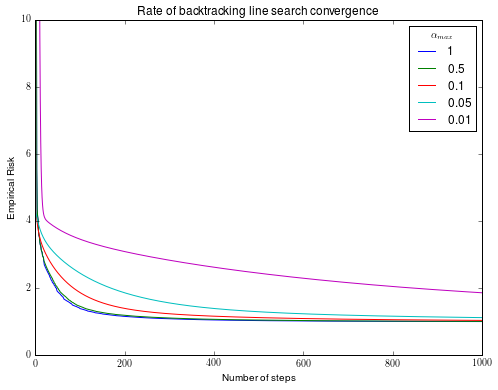

In [201]:
plt.figure(figsize=(8,6))
plt.rc('text', usetex=True)
plt.ylim((0,10))
for alpha in [1,0.5,0.1,0.05,0.01]:
    plt.plot(np.arange(1001.0), backtracking_line_search(X, y, compute_square_loss, compute_square_loss_gradient, alpha_max = alpha)[1], label=str(alpha))
    plt.legend(title=r'\alpha_{max}')
    plt.xlabel('Number of steps')
    plt.ylabel('Empirical Risk')
    plt.title('Rate of backtracking line search convergence')
plt.savefig('figures/2_4_3.png')

In [174]:
%timeit backtracking_line_search(X, y, compute_square_loss, compute_square_loss_gradient, lambda_reg=0, num_iter=1000, alpha_max = 1, tau = 0.5, c = 0.5)
%timeit batch_grad_descent(X, y, alpha=0.1, num_iter=1000, check_gradient=False)

10 loops, best of 3: 141 ms per loop
10 loops, best of 3: 21 ms per loop


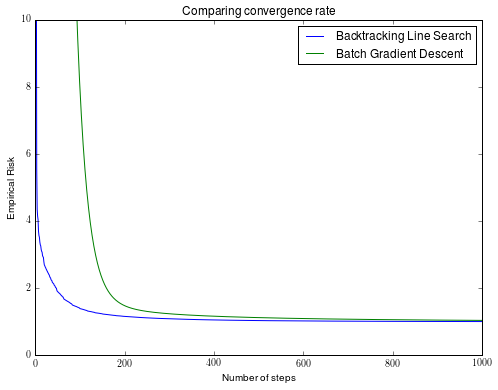

In [175]:
plt.figure(figsize=(8,6))
plt.rc('text', usetex=True)
plt.ylim((0,10))
plt.plot(np.arange(1001.0), backtracking_line_search(X, y, compute_square_loss, compute_square_loss_gradient, lambda_reg=0, num_iter=1000, alpha_max = 1, tau = 0.5, c = 0.5)[1], label='Backtracking Line Search')
plt.plot(np.arange(1001.0), batch_grad_descent(X, y, alpha=0.1, num_iter=1000, check_gradient=False)[1], label=r'Batch Gradient Descent')
plt.legend()
plt.xlabel('Number of steps')
plt.ylabel('Empirical Risk')
plt.title('Comparing convergence rate')
plt.savefig('figures/2_4_3a.png')

In [176]:
########################################
####Q2.5.2: The l2 regularized square loss function (ridge regression)

def compute_regularized_square_loss(X, y, theta, lambda_reg):
    """
    Given a set of X, y, theta, compute the l2 regularized square loss for
    predicting y with X*theta
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D array of size (num_features)
    
    Returns:
        loss - the square loss, scalar
    """
    return 1.0/(2.0 * X.shape[0]) * np.dot(np.dot(X,theta) - y, np.dot(X,theta) - y)+ lambda_reg*np.dot(theta, theta)

In [177]:
###################################################
###Q2.5.1 (not in assignment but needed in later function):
###Compute the gradient of Regularized Batch Gradient Descent
def compute_regularized_square_loss_gradient(X, y, theta, lambda_reg):
    """
    Compute the gradient of L2-regularized square loss function given X, y and theta
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D numpy array of size (num_features)
        lambda_reg - the regularization coefficient
    
    Returns:
        grad - gradient vector, 1D numpy array of size (num_features)
    """
    return 1.0/X.shape[0] * np.dot((np.dot(X,theta) - y).T, X) + 2 * lambda_reg * theta

In [178]:
###################################################
###Q2.5.3: Batch Gradient Descent with regularization term
def regularized_grad_descent(X, y, alpha=0.1, lambda_reg=1, num_iter=1000, grad_check = False):
    """
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - step size in gradient descent
        lambda_reg - the regularization coefficient
        numIter - number of iterations to run
        grad_check - if true check gradient caclulations
        
    Returns:
        theta_hist - the history of parameter vector, 2D numpy array of size (num_iter+1, num_features) 
        loss_hist - the history of regularized loss value, 1D numpy array
    """
    (num_instances, num_features) = X.shape
    theta = np.ones(num_features) #Initialize theta
    theta_hist = np.zeros((num_iter+1, num_features))  #Initialize theta_hist
    loss_hist = np.zeros(num_iter+1) #Initialize loss_hist
    
    ##Update loss_hist and theta_hist with iteration 0 values:
    
    theta_hist[0,] = theta
    loss_hist[0] = compute_regularized_square_loss(X, y, theta, lambda_reg)
    
    for i in range(num_iter):
        grad = compute_regularized_square_loss_gradient(X, y, theta, lambda_reg)
        
        if grad_check:
            if not generic_gradient_checker(X, y, theta, compute_regularized_square_loss, compute_regularized_square_loss_gradient, lambda_reg=lambda_reg, epsilon=0.001, tolerance=1e-4):
                raise ValueError('Gradient calculation incorrect')
        
        norm_grad = grad / ((np.dot(grad, grad))**0.5)
        theta = theta - alpha * norm_grad
        theta_hist[i+1,] = theta
        loss_hist[i+1] = compute_regularized_square_loss(X, y, theta, lambda_reg)
    
    print loss_hist[-1]
    return theta_hist, loss_hist    

1.90075163132


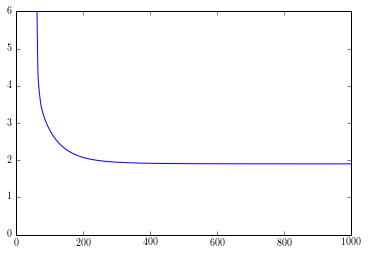

In [179]:
plt.figure()
plt.ylim((0,6))
plt.plot(np.arange(1001.0), regularized_grad_descent(X, y, alpha=0.1, lambda_reg=0.0122, num_iter=1000, grad_check=True)[1])

1e-07 {'train_MSE': 1.0042558664743111, 'val_MSE': 1.6066264984981349, 'log10(lambda_reg)': -7.0}
1e-05 {'train_MSE': 1.0044062665813569, 'val_MSE': 1.6044646033324521, 'log10(lambda_reg)': -5.0}
0.001 {'train_MSE': 1.0182400794458837, 'val_MSE': 1.4980387249423472, 'log10(lambda_reg)': -3.0}
0.1 {'train_MSE': 2.6405689620599349, 'val_MSE': 1.7419316030802248, 'log10(lambda_reg)': -1.0}
10.0 {'train_MSE': 3.9348565339073871, 'val_MSE': 2.4871543144427966, 'log10(lambda_reg)': 1.0}
1000.0 {'train_MSE': 3.980081528167708, 'val_MSE': 2.5483283178598515, 'log10(lambda_reg)': 3.0}
100000.0 {'train_MSE': 3.980752344740405, 'val_MSE': 2.5494133864498072, 'log10(lambda_reg)': 5.0}
10000000.0 {'train_MSE': 3.9807591035327721, 'val_MSE': 2.5494243373204135, 'log10(lambda_reg)': 7.0}


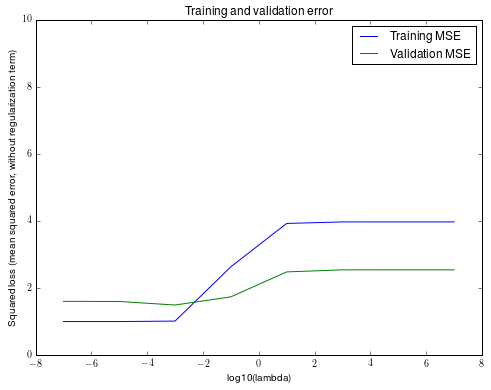

In [180]:
#############################################
##Q2.5.5: Visualization of Regularized Batch Gradient Descent
##X-axis: log(lambda_reg)
##Y-axis: square_loss
import os

def get_val_loss_for_lambda_reg(lambda_reg):
    opt_thetas = backtracking_line_search(data['X_train'], data['y_train'], compute_regularized_square_loss, compute_regularized_square_loss_gradient, lambda_reg = lambda_reg)[0][-1]
    train_MSE = compute_square_loss(data['X_train'], data['y_train'], opt_thetas)
    val_MSE = compute_square_loss(data['X_test'], data['y_test'], opt_thetas)
    return {'log10(lambda_reg)':np.log10(lambda_reg), 'train_MSE':train_MSE, 'val_MSE':val_MSE}

def make_loss_plots(lambda_list):

    loss_vals = []
    
    for lambda_reg in lambda_list:
        loss_vals_lambda = get_val_loss_for_lambda_reg(lambda_reg)
        print lambda_reg, loss_vals_lambda
        loss_vals.append(loss_vals_lambda)
    
    loss_vals = pd.DataFrame(loss_vals)
            
    plt.figure(figsize=(8,6))
    plt.ylim((0,10))
    plt.plot(loss_vals['log10(lambda_reg)'], loss_vals['train_MSE'], label = 'Training MSE')
    plt.plot(loss_vals['log10(lambda_reg)'], loss_vals['val_MSE'], label = 'Validation MSE')
    plt.legend(loc='best')
    plt.xlabel('log10(lambda)')
    plt.ylabel('Squared loss (mean squared error, without regularization term)')
    plt.title('Training and validation error')
    
    fig_index = 1
    file_path = 'figures/2_5_5_{}.png'.format(fig_index)
    while os.path.isfile(file_path):
        fig_index += 1
        file_path = 'figures/2_5_5_{}.png'.format(fig_index)
    
    plt.savefig(file_path)

lambda_list = np.logspace(-7,7,8)
make_loss_plots(lambda_list)

1e-05 {'train_MSE': 1.0044062665813569, 'val_MSE': 1.6044646033324521, 'log10(lambda_reg)': -5.0}
7.19685673001e-05 {'train_MSE': 1.004927342479679, 'val_MSE': 1.5955425228823021, 'log10(lambda_reg)': -4.1428571428571432}
0.000517947467923 {'train_MSE': 1.0102843649167768, 'val_MSE': 1.5459825923996193, 'log10(lambda_reg)': -3.2857142857142856}
0.00372759372031 {'train_MSE': 1.085302977575157, 'val_MSE': 1.3330112226018382, 'log10(lambda_reg)': -2.4285714285714288}
0.0268269579528 {'train_MSE': 1.7042602442090709, 'val_MSE': 1.300798177380178, 'log10(lambda_reg)': -1.5714285714285716}
0.193069772888 {'train_MSE': 3.075565297042465, 'val_MSE': 1.9756094290330317, 'log10(lambda_reg)': -0.71428571428571441}
1.38949549437 {'train_MSE': 3.7627597518922893, 'val_MSE': 2.3580381251493403, 'log10(lambda_reg)': 0.14285714285714232}
10.0 {'train_MSE': 3.9348565339073871, 'val_MSE': 2.4871543144427966, 'log10(lambda_reg)': 1.0}


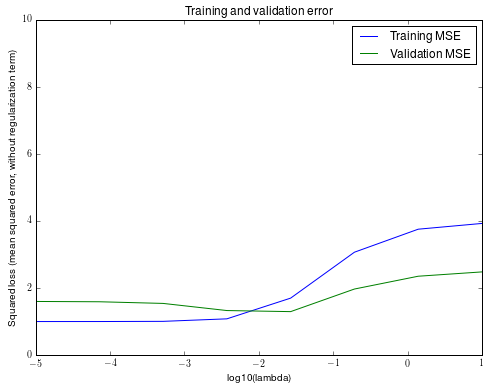

In [181]:
lambda_list2 = np.logspace(-5,1,8)
make_loss_plots(lambda_list2)

0.00316227766017 {'train_MSE': 1.069524710493577, 'val_MSE': 1.3567719295528253, 'log10(lambda_reg)': -2.5}
0.00464158883361 {'train_MSE': 1.1117170156613758, 'val_MSE': 1.3019285025271186, 'log10(lambda_reg)': -2.3333333333333335}
0.00681292069058 {'train_MSE': 1.1765508912094562, 'val_MSE': 1.2545274383098484, 'log10(lambda_reg)': -2.1666666666666665}
0.01 {'train_MSE': 1.2715463915799328, 'val_MSE': 1.2254679623897766, 'log10(lambda_reg)': -2.0}
0.0146779926762 {'train_MSE': 1.4045000384683914, 'val_MSE': 1.2250289802301115, 'log10(lambda_reg)': -1.8333333333333335}
0.0215443469003 {'train_MSE': 1.58190449060042, 'val_MSE': 1.261583988822234, 'log10(lambda_reg)': -1.6666666666666667}
0.0316227766017 {'train_MSE': 1.80558051323147, 'val_MSE': 1.3388689972181536, 'log10(lambda_reg)': -1.5}
0.0464158883361 {'train_MSE': 2.0686356348981971, 'val_MSE': 1.4532618988651347, 'log10(lambda_reg)': -1.3333333333333335}
0.0681292069058 {'train_MSE': 2.3544073178741307, 'val_MSE': 1.593103227616

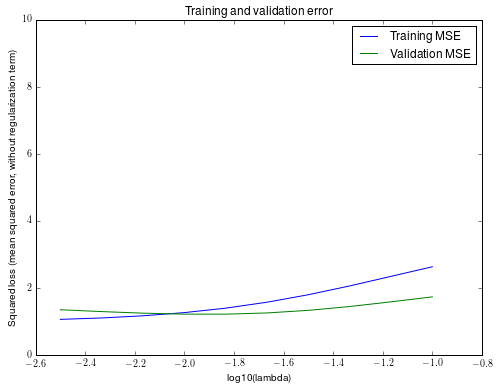

In [183]:
lambda_list3 = np.logspace(-2.5,-1,10)
make_loss_plots(lambda_list3)

0.0115 {'train_MSE': 1.3151751554757833, 'val_MSE': 1.2214899478654595, 'log10(lambda_reg)': -1.9393021596463884}
0.0116 {'train_MSE': 1.3180533271019528, 'val_MSE': 1.2213552104619851, 'log10(lambda_reg)': -1.9355420107730816}
0.0117 {'train_MSE': 1.3209267244547613, 'val_MSE': 1.2212701322951391, 'log10(lambda_reg)': -1.9318141382538383}
0.0118 {'train_MSE': 1.3237965196875636, 'val_MSE': 1.221204937000133, 'log10(lambda_reg)': -1.9281179926938745}
0.0119 {'train_MSE': 1.3266573043335281, 'val_MSE': 1.2211229146611116, 'log10(lambda_reg)': -1.9244530386074692}
0.012 {'train_MSE': 1.3295202592944864, 'val_MSE': 1.2210961732914103, 'log10(lambda_reg)': -1.9208187539523751}
0.0121 {'train_MSE': 1.3323753318013138, 'val_MSE': 1.2210721190983258, 'log10(lambda_reg)': -1.9172146296835499}
0.0122 {'train_MSE': 1.3352269291652477, 'val_MSE': 1.2210649717847668, 'log10(lambda_reg)': -1.9136401693252518}
0.0123 {'train_MSE': 1.3380742955823781, 'val_MSE': 1.2210801683562451, 'log10(lambda_reg)

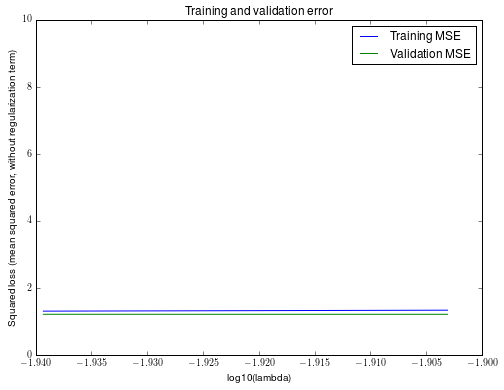

In [184]:
lambda_list4 = np.linspace(0.0115,0.0125,11)
make_loss_plots(lambda_list4)

loading the dataset
Split into Train and Test
Scaling all to [0, 1]
loading the dataset
Split into Train and Test
Scaling all to [0, 1]
loading the dataset
Split into Train and Test
Scaling all to [0, 1]
loading the dataset
Split into Train and Test
Scaling all to [0, 1]
loading the dataset
Split into Train and Test
Scaling all to [0, 1]
loading the dataset
Split into Train and Test
Scaling all to [0, 1]
loading the dataset
Split into Train and Test
Scaling all to [0, 1]
loading the dataset
Split into Train and Test
Scaling all to [0, 1]
loading the dataset
Split into Train and Test
Scaling all to [0, 1]


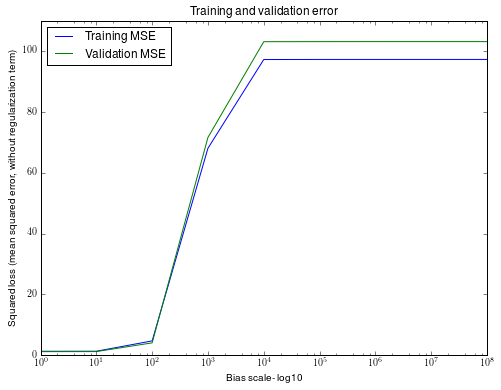

In [185]:
##2.5.6 Regularizing the bias term B

def load_split_proc_data_with_scaled_bias(bias_scale):
    '''Load, splits, and scales the assignment 1 data.
    
    Args:
        bias_scale - coefficient for 1's vector appended to dataset
        
    Returns:
        {X_train, X_test, y_train, y_test} - the training/test data
    '''
    
    
    #Loading the dataset
    print('loading the dataset')
    
    df = pd.read_csv('hw1-data.csv', delimiter=',')
    X = df.values[:,:-1]
    y = df.values[:,-1]

    print('Split into Train and Test')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =100, random_state=10)

    print("Scaling all to [0, 1]")
    X_train, X_test = feature_normalization(X_train, X_test)
    X_train = np.hstack((X_train, bias_scale * np.ones((X_train.shape[0], 1))))  # Add scaled bias term
    X_test = np.hstack((X_test, bias_scale * np.ones((X_test.shape[0], 1)))) # Add scaled bias term

    return {'X_train': X_train,'X_test':  X_test, 'y_train':  y_train, 'y_test': y_test}

def make_learning_curves_for_diff_bias_scales(bias_scales):
    loss_vals = []
    
    for bias in bias_scales:
        #Split data with bias scaled
        data = load_split_proc_data_with_scaled_bias(bias)
        
        #Use backtracking line search to determine optimal weights (thetas)
        opt_thetas = backtracking_line_search(data['X_train'], data['y_train'], compute_regularized_square_loss, compute_regularized_square_loss_gradient, lambda_reg = .0122)[0][-1]
        
        #Determine training MSE (only square loss part, without regularization penalty)
        train_MSE = compute_square_loss(data['X_train'], data['y_train'], opt_thetas)
        
        #Determine test MSE (only square loss part, without regularization penalty)
        val_MSE = compute_square_loss(data['X_test'], data['y_test'], opt_thetas)
        loss_vals_bias = {'Bias_scale':bias, 'train_MSE':train_MSE, 'val_MSE':val_MSE}
        loss_vals.append(loss_vals_bias)
    
    loss_vals = pd.DataFrame(loss_vals)
    
    plt.figure(figsize=(8,6))
    plt.ylim((0,110))
    ax = plt.gca()
    ax.set_xscale('log')
    plt.plot(loss_vals['Bias_scale'], loss_vals['train_MSE'], label = 'Training MSE')
    plt.plot(loss_vals['Bias_scale'], loss_vals['val_MSE'], label = 'Validation MSE')
    plt.legend(loc='best')
    plt.xlabel('Bias scale- log10')
    plt.ylabel('Squared loss (mean squared error, without regularization term)')
    plt.title('Training and validation error')
    plt.savefig('figures/2_5_6.png')
    return

make_learning_curves_for_diff_bias_scales(np.logspace(0,8,9))

In [186]:
#############################################
###2.5.8 - Time for gradient step
%timeit regularized_grad_descent(X, y, alpha=0.1, lambda_reg=0.012, num_iter=1000)

1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
1.89185128405
10 loops, best of 3: 32.7 ms per loop


In [187]:
#############################################
###2.5.8 - Optimal theta
opt_thetas = regularized_grad_descent(X, y, alpha=0.1, lambda_reg=0.012, num_iter=1000)[0][-1]
print max(opt_thetas), min(opt_thetas)


1.89185128405
2.28831501173 -3.59973449056


In [190]:
#############################################
###Q2.6.2: Implementing Stochastic Gradient Descent
def stochastic_grad_descent(X, y, alpha=0.1, lambda_reg=1, num_iter=1000):
    """
    In this question you will implement stochastic gradient descent with a regularization term
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        alpha - string or float. step size in gradient descent
                NOTE: In SGD, it's not always a good idea to use a fixed step size. Usually it's set to 1/sqrt(t) or 1/t
                if alpha is a float, then the step size in every iteration is alpha.
                if alpha == "1/sqrt(t)", alpha = 1/sqrt(t)
                if alpha == "1/t", alpha = 1/t
        lambda_reg - the regularization coefficient
        num_iter - number of epochs (i.e number of times) to go through the whole training set
        check_grad - if true check gradient calculations
        
    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size (num_iter, num_instances, num_features) 
        loss hist - the history of regularized loss function vector, 2D numpy array of size(num_iter, num_instances)
    """
    ##Initialize arrays
    num_instances, num_features = X.shape[0], X.shape[1]
    theta = np.ones(num_features) #Initialize theta
    theta_hist = np.zeros((num_iter, num_instances, num_features))  #Initialize theta_hist
    loss_hist = np.zeros((num_iter, num_instances)) #Initialize loss_hist
    
    t = 1.0 ##Step counter
    
    ##Parse alpha
    
    if type(alpha) == float:
        alpha = alpha
        alpha_fun = (lambda t: alpha)
    
    elif alpha == "1/sqrt(t)":
        alpha = 1.0/np.sqrt(t)
        alpha_fun = (lambda t: 1/np.sqrt(t))
    
    elif alpha == "1/t":
        alpha = 1.0/t
        alpha_fun = (lambda t: 1/t)
        
    else:
        raise ValueError('Alpha is (1) a float; (2) "1/sqrt(t)"; or (3) "1/t"')   
        
    for iteration in range(num_iter):
        ##Shuffle the training data
        np.random.seed(6354135)
        permute = np.random.permutation(np.arange(num_instances))
        X = X[permute]
        y = y[permute]

        for i in range(num_instances):
            
            grad = (X[i,:] * (np.dot(X[i,:], theta) - y[i]) + 2*lambda_reg*theta)
            norm_grad = grad / ((np.dot(grad, grad))**0.5)
            theta = theta - alpha * grad
            theta_hist[iteration, i,] = theta
                                     
            loss =  compute_regularized_square_loss(X, y, theta, lambda_reg)
            loss_hist[iteration, i] = loss
                                     
            t += 1.0
            alpha = alpha_fun(t)
    
    print alpha, loss_hist[-1,-1]
    
    return theta_hist, loss_hist

loading the dataset
Split into Train and Test
Scaling all to [0, 1]
0.05 5.29429269756
0.001 1.87830715806
0.005 1.94247284506
9.999900001e-06 1569257.29711
0.0031622618489 3.7977051325e+44


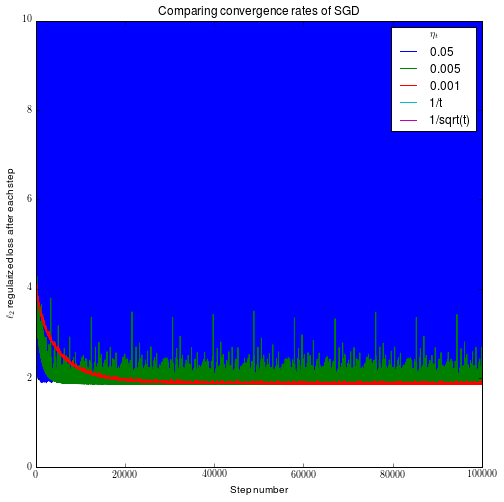

In [192]:
#############################################
###Q2.6.3: Testing step sizes for SGD
data = load_split_proc_data()
sgd_results_0 = stochastic_grad_descent(data['X_train'], data['y_train'], alpha=0.05, lambda_reg=0.012)
sgd_results_1 = stochastic_grad_descent(data['X_train'], data['y_train'], alpha=0.001, lambda_reg=0.012)
sgd_results_2 = stochastic_grad_descent(data['X_train'], data['y_train'], alpha=0.005, lambda_reg=0.012)
sgd_results_3 = stochastic_grad_descent(data['X_train'], data['y_train'], alpha="1/t", lambda_reg=0.012)
sgd_results_4 = stochastic_grad_descent(data['X_train'], data['y_train'], alpha="1/sqrt(t)", lambda_reg=0.012)

plt.figure(figsize=(8,8))
plt.ylim((0,10))
plt.plot(np.arange(100000), np.ravel(sgd_results_0[1]), label='0.05')
plt.plot(np.arange(100000), np.ravel(sgd_results_2[1]), label='0.005')
plt.plot(np.arange(100000), np.ravel(sgd_results_1[1]), label='0.001')
plt.plot(np.arange(100000), np.ravel(sgd_results_3[1]), label='1/t')
plt.plot(np.arange(100000), np.ravel(sgd_results_4[1]), label='1/sqrt(t)')
plt.title('Comparing convergence rates of SGD')
plt.xlabel('Step number')
plt.ylabel(r'$\ell_2$ regularized loss after each step')
plt.legend(loc='best', title=r'$\eta_t$')
plt.savefig('figures/2_6_3.png')

9.87947046038e-06 3.4986094668
8.91265597148e-05 2.2189576174
0.00045045045045 1.87828822417
0.000757575757576 1.87977168207
0.000813008130081 1.33309631536e+19
0.000819000819001 inf
0.000819604950414 nan


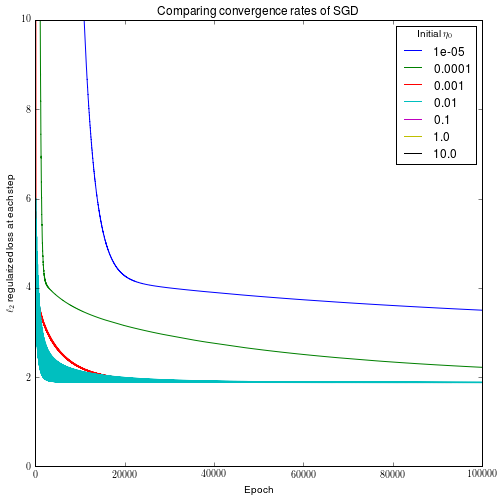

In [193]:
#############################################
###Q2.6.4: Implementing SGD with eta_t step size
def stochastic_grad_descent_eta_0(X, y, eta_0=1, lambda_reg=1, num_iter=1000):
    """
    This version of SGD takes an additional argument, eta_0, and uses an alternate
    step size dependent on t (step number), specificall of the form
        eta_0 / (1 + eta_0 * lambda_reg * t)
    
    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        eta_0 - a constant use to set the step size
        lambda_reg - the regularization coefficient
        num_iter - number of epochs (i.e number of times) to go through the whole training set
    
    Returns:
        theta_hist - the history of parameter vector, 3D numpy array of size (num_iter, num_instances, num_features) 
        loss hist - the history of regularized loss function vector, 2D numpy array of size(num_iter, num_instances)
    """
    ##Initialize arrays
    num_instances, num_features = X.shape[0], X.shape[1]
    
    theta = np.ones(num_features) #Initialize theta
    theta_hist = np.zeros((num_iter, num_instances, num_features))  #Initialize theta_hist
    loss_hist = np.zeros((num_iter, num_instances)) #Initialize loss_hist
    
    t = 1.0 ##Step counter
    
    ##New step rule:
    
    eta_t_func = (lambda x: (eta_0)/(1+eta_0*lambda_reg*x))
    eta_t = eta_t_func(t)
    
    ##Permutation of range(num_instances)- shuffle X and y
    np.random.seed(6354135)
    permute = np.random.permutation(np.arange(num_instances))
    X = X[permute]
    y = y[permute]
    
    ##Loop through theta update:
    for iteration in range(num_iter):
        
        for i in range(num_instances):
            eta_t = eta_t_func(t)
            
            grad = (X[i,:] * (np.dot(X[i,:], theta) - y[i]) + 2*lambda_reg*theta)
            norm_grad = grad / ((np.dot(grad, grad))**0.5)
            theta = theta - eta_t * grad
            theta_hist[iteration, i,] = theta
                                     
            loss =  compute_regularized_square_loss(X, y, theta, lambda_reg)
            loss_hist[iteration, i] = loss
                                     
            t += 1.0
    
    
    print eta_t, loss_hist[-1,-1]
    return theta_hist, loss_hist

plt.figure(figsize=(8,8))
plt.ylim((0,10))
for eta_val in np.logspace(-5,1,7):
    plt.plot(np.arange(100000), np.ravel(stochastic_grad_descent_eta_0(data['X_train'], data['y_train'], eta_0=eta_val, lambda_reg=0.0122)[1]), label=str(eta_val))
    
plt.title('Comparing convergence rates of SGD')
plt.xlabel('Epoch')
plt.ylabel(r'$\ell_2$ regularized loss at each step')
plt.legend(loc='best', title=r'Initial $\eta_0$')
plt.savefig('figures/2_6_4.png')

In [194]:
%timeit stochastic_grad_descent(data['X_train'], data['y_train'], alpha=0.001, lambda_reg=0.012)
%timeit stochastic_grad_descent(data['X_train'], data['y_train'], alpha=0.005, lambda_reg=0.012)
%timeit stochastic_grad_descent(data['X_train'], data['y_train'], alpha="1/t", lambda_reg=0.012)
%timeit stochastic_grad_descent(data['X_train'], data['y_train'], alpha="1/sqrt(t)", lambda_reg=0.012)
%timeit stochastic_grad_descent_eta_0(data['X_train'], data['y_train'], eta_0=0.1, lambda_reg=0.0122)

0.001 1.87830715806
0.001 1.87830715806
0.001 1.87830715806
0.001 1.87830715806
1 loops, best of 3: 2.4 s per loop
0.005 1.94247284506
0.005 1.94247284506
0.005 1.94247284506
0.005 1.94247284506
1 loops, best of 3: 2.49 s per loop
9.999900001e-06 1569257.29711
9.999900001e-06 1569257.29711
9.999900001e-06 1569257.29711
9.999900001e-06 1569257.29711
1 loops, best of 3: 2.92 s per loop
0.0031622618489 3.7977051325e+44
0.0031622618489 3.7977051325e+44
0.0031622618489 3.7977051325e+44
0.0031622618489 3.7977051325e+44
1 loops, best of 3: 3.07 s per loop
0.000813008130081 1.33309631536e+19
0.000813008130081 1.33309631536e+19
0.000813008130081 1.33309631536e+19
0.000813008130081 1.33309631536e+19
1 loops, best of 3: 2.68 s per loop


loading the dataset
Split into Train and Test
Scaling all to [0, 1]
1.90075163132
0.001 1.88717608892
0.000757575757576 1.87977168207


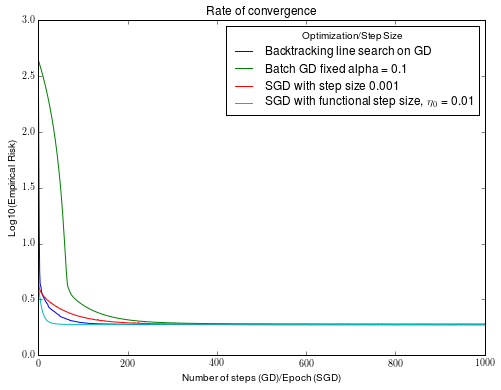

In [199]:
################################################
###Q2.6.6 Visualization that compares the convergence speed of batch
###and stochastic gradient descent for various approaches to step_size
##X-axis: Step number (for gradient descent) or Epoch (for SGD)
##Y-axis: log(objective_function_value)


data = load_split_proc_data()
X_train = data['X_train']
y_train = data['y_train']
plt.figure(figsize=(8,6))

plt.plot(np.arange(1001.0), np.log10(backtracking_line_search(X, y, compute_regularized_square_loss, compute_regularized_square_loss_gradient, lambda_reg=0.0122)[1]), label='Backtracking line search on GD')
plt.plot(np.arange(1001.0), np.log10(regularized_grad_descent(X, y, alpha = 0.1, lambda_reg=0.0122)[1]), label='Batch GD fixed alpha = 0.1')
plt.plot(np.arange(1000.0), np.log10(stochastic_grad_descent(X, y, alpha=0.001, lambda_reg=.0122, num_iter=1000)[1][:,-1]), label='SGD with step size 0.001')
plt.plot(np.arange(1000.0), np.log10(stochastic_grad_descent_eta_0(X, y, eta_0=0.01, lambda_reg=0.0122)[1][:,-1]), label='SGD with functional step size, $\eta_0$ = 0.01')
plt.legend(title='Optimization/Step Size')
plt.xlabel('Number of steps (GD)/Epoch (SGD)')
plt.ylabel('Log10(Empirical Risk)')
plt.title('Rate of convergence')
plt.savefig('figures/2_6_6.png')
